<a id='root'></a>
![Project Logo](Project_Logo.pdf)

## PyUltraLight NBody

# Build 0.28b (02 Jan 020)

* Y. Wang: [yourong.f.wang@auckland.ac.nz](mailto:yourong.f.wang@auckland.ac.nz)
* J. Zagorac
* R. Easther
* N. Guo

***Designed for PyULN9. Requires ULHelper 6 or later.***
***

## Structure and Intended Workflows

### New Simulation
[Initialize](#init) -> [Simulation Parameters](#ULSettings) -> [Scenarios](#demos) -> [Simulation](#run) (-> [Data Loading](#load) -> [Analysis](#plot))

### <font color = grey>Re-Running a Previous Experiment</font>
[Initialize](#init) -> [Data Loading](#load) -> *Modifying its Configs, if Necessary* -> [Simulation](#run)

### <font color = grey>Analyzing Old Results</font>
[Initialize](#init) -> [Data Loading](#load) -> [Analysis](#plot)

__NOTE:__ When you load the output files of a run, the configuration and initial conditions associated with that run will also be loaded into memory.

<a id='init'></a>
# Initialization and Program Settings

## Loading Packages



In [2]:
###### Do not touch
MinVersion = 10
MinHVersion = 6

import PyUltraLight_NBody_9 as PyUL
import PyUL_Helper as PyULH

if (PyULH.S_version < MinHVersion) or (PyUL.S_version < MinVersion):
    raise RuntimeError("You need the latest integrator!")

import numpy as np
import math

import numba
import numexpr as ne

import pyfftw
import os
import sys
import multiprocessing
import numpy

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec
import matplotlib.animation
from matplotlib.offsetbox import AnchoredText

import scipy.fft

import h5py
from IPython.core.display import clear_output, display

%reload_ext autoreload
%autoreload 2
%matplotlib inline

print("==============================================")
print(f"PyULN: Axion Mass Used is {PyUL.axion_E} eV. This gives rise to:\n")

print(f"\
1 Mass Unit    = {PyUL.mass_unit:.5g} kg = {PyUL.convert_back(1,'solar_masses','m'):.4g} MSol\n\
1 Length Unit  = {PyUL.length_unit:.5g} m  = {PyUL.convert_back(1,'kpc','l'):.4g} kpc\n\
1 Time Unit    = {PyUL.time_unit:.5g} s  = {PyUL.convert_back(1,'Myr','t')/1000:.4g} Gyr\n\n\
1 Density Unit = {PyUL.mass_unit/PyUL.length_unit**3:.5g} kg/m^3 = {PyUL.mass_unit/PyUL.length_unit**3/PyUL.CritDens} Critical Density\n\
1 Speed Unit   = {PyUL.length_unit/PyUL.time_unit:.5g} m/s\n\
1 Energy Unit  = {PyUL.mass_unit*PyUL.length_unit**2/PyUL.time_unit**2:.5g} J\
")


PyULN: Axion Mass Used is 1e-22 eV. This gives rise to:

1 Mass Unit    = 4.4304e+36 kg = 2.227e+06 MSol
1 Length Unit  = 1.1838e+21 m  = 38.36 kpc
1 Time Unit    = 2.3694e+18 s  = 75.13 Gyr

1 Density Unit = 2.6705e-27 kg/m^3 = 0.31 Critical Density
1 Speed Unit   = 499.62 m/s
1 Energy Unit  = 1.1059e+42 J


## Visualization Preferences
Initialize the colors of black holes, contours, and energy lines.

In [3]:
Palette = 'magma'
mpl.style.use('seaborn')
########################################
## Defines Visualization Colors, v0.25
# BH Trajectory
Colors = np.array([[209,17,65],[0,177,89],[0,174,219],[243,119,53],[255,196,37]])/255

# NBody
ENStyle = '--'
ENColor = '#cfaf8a' # NBody

EKColor = '#cf838a'
EPColor = '#8acf99'

# ULDM
EUStyle = '-.'
EUColor = '#8d4b66' # ULDM

EQColor = '#4d7e4e' # Kinetic 
ERColor = '#545b7e' # Self-Interaction
EGColor = '#69567c' # Particle Potential


# Totals
ETStyle = '-'
ETColor = '#272727'

# Auxiliary 
HelperStyle = 'k.'

## Folder and Space Management:

In [43]:
save_path = '2021Runs'  # Set output directory

PyULH.DSManagement(save_path)

2021Runs : The current size of the folder is 1417.044 Mib
2021Runs : Do You Wish to Delete All Files Currently Stored In This Folder? [Y] 

Y
Folder Cleaned! 

2021Runs : Save Folder Created.


[**<font color=blue>Back to the Top</font>**](#root)
<a id='ULSettings'></a>
# Simulation Parameters

In [42]:
##================================================================
# Space Settings
resol = 420
length = 2 # 1 code unit is ~38 kpc x (1e-22/m_a)^0.5
length_units = ''  # Accepted units: 'm', 'km', 'pc', 'kpc', 'Mpc', 'ly', and '' for dimensionless units.

# Time Settings
duration = 0.003 #1 code unit is ~70 Gyr (independent of axion mass assumption)
duration_units = ''  # Accepted units: 's', 'yr', 'kyr', 'Myr', and '' for dimensionless units
start_time = 0. # Should be given in the same units as duration. 
step_factor = 1e3 # Change this to a larger number if velocities are sufficiently low that constraint on timestep can be relaxed. 

# Snapshot Settings A
save_number = 120
# Recommended Save Number Cap: 120
# Depending on resolution, this could require significant disk space.

# Runge-Kutta Steps for NBody
NS = 4 # 1,4,8,16,... NBody Integration Steps per ULD Step. 1 -> Euler

##================================================================
## Other Flags
# Set units for soliton parameters
s_mass_unit = ''     #Accepted units: 'kg', 'solar_masses', 'M_solar_masses', and '' for dimensionless units
s_position_unit = '' #Accepted units: 'm', 'km', 'pc', 'kpc', 'Mpc', 'ly', and '' for dimensionless units
s_velocity_unit = '' #Accepted units: 'm/s', 'km/s', 'km/h', and '' for dimensionless units

# Rules ditto.
m_mass_unit = ''
m_position_unit = ''
m_velocity_unit = ''

# Density, if Uniform Background Flag is Set to 'True'
# 1 Code Density Unit is equal the universe's critical matter density, 2.67e-27 kg/m^3.
density_unit = '' # Accepted units: 'MSol/pc3', 'kg/m3', and '' for dimensionless units

#Formats to save
hdf5 = False
npz = False
npy = True

#Data to save
#0
save_rho = False # Saves density data for entire 3D simulation grid
#1
save_psi = False # Saves ULD Phase Data in plane
#2
save_plane = True # Saves density data for plane z = 0
#3
save_energies = True # Saves integrated gravitational, kinetic and total energies as lists
#4
save_line = False # Saves density data for line y = 0, z = 0. Useful for examining intereference patterns. 
#5
save_testmass = True # Saves trajectory and 3-velocity of a test mass thrown into the system.   
#6
save_phi = False
#7
save_phi_plane = True
#8
save_gradients = True
#9
save_phase_plane = True

save_options = [save_rho,save_psi,save_plane,save_energies,save_line,save_testmass,save_phi,save_phi_plane,save_gradients,save_phase_plane]

SaveSizeEstimate = PyULH.SSEst(save_options,save_number,resol)

print('Estimated Save Size (GiB): %.02f' % SaveSizeEstimate )

#================================================================
# Do not touch
resol = (scipy.fft.next_fast_len(resol)) # Uses a nearby and faster resolution.
while resol%2:
    resol = scipy.fft.next_fast_len(resol+1)
    print(resol)
num_threads = multiprocessing.cpu_count()
print("Available CPU threads for this run: ",num_threads)
print(f"Simulating a {length} ({length_units}) box at resolution: {resol} cubed.")

LengthFS = PyUL.convert(length, length_units, 'l')

GridLenFS = LengthFS/(resol)

GridLenPC = PyUL.convert_back(GridLenFS,'pc','l')

print(f"The grid subdivision is {length/resol:.4f} in specified units. This is {GridLenFS:.4f} code units.")

central_mass = 0 # Not Implemented Anymore. Keep for code compatibility.

ULHelper: Saving Mass Density Data (2D)
ULHelper: Saving ULD Argument Data (2D)
ULHelper: Saving Gravitational Field Data (2D)
ULHelper: Saving NBody Gradient Data
ULHelper: Saving NBody Position Data
Estimated Save Size (GiB): 1.58
Available CPU threads for this run:  16
Simulating a 2 () box at resolution: 420 cubed.
The grid subdivision is 0.0048 in specified units. This is 0.0048 code units.


## <font color=green>Gravitational Field Smoothing</font>
Instead of coding in the idealistic $\frac{m}{r}$ potential, we approximate it with $\frac{am}{ar+e^{-ar}}$. 

The modified potential is a useful approximation of a point mass in a distance, and puts an exponential cap on the infinite potential well, which reduces the impact of numerical artefacts.


The smoothing factor, $a$, is also defined here.


The differences between the two potentials are characterised in the program output box.

The Smoothing factor is 453.305


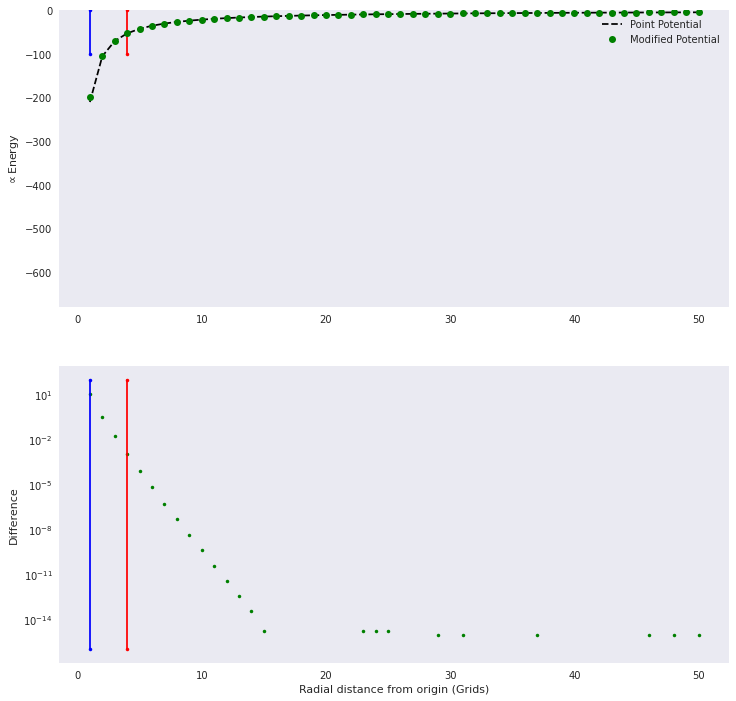

Generating Field Smoothing Report:
  The simulation runs on a 420^3 grid with total side length 2.0
  The simulation grid size is 0.0048 Code Units,
  

==========Grid Counts of Important Features=========

  Radius outside which the fields are practically indistinguishable (Grids): 4
  Modified Potential HWHM (Grids): 1


In [35]:
#================================================================
a = (2-PyUL.LW(np.exp(-2)))/LengthFS*resol
a = np.real(a)

print(f"The Smoothing factor is {a:.3f}")

PyULH.SmoothingReport(a,resol,LengthFS)

[**<font color=blue>Back to the Top</font>**](#root)
<a id='demos'></a>
# Scenarios

## The Following Examples are Included in this Version
Each scenario has an extra set of parameters for you to tweak. Execute only one at a time.

### 01. [Elliptical Orbit](#demo_elli)
(Code Units Only)
A Keplerian model of two objects orbiting each other. 

Available parameters:
 
* *m1,m2*: mass of the two objects.
* *Ratio1,Ratio2*: mBH/mTotal for objects 1 and 2.
* *Aphelion*: Farthest Distance between the objects. 
* *Eccentricity*: Orbit Eccentricity

**NOTE**: Simulations always start from Aphelion.


### 02. [Scattering](#demo_scatter)
(Code Units Only)
A simple scattering model where the centre of mass, in theory, stays at origin.

Available parameters:
 
* *Uniform*: If yes, *Ratio* will be ignored and the objects are black holes in a uniform ULD Backgroud.
* *m1,m2*: mass of the two objects.
* *Ratio1,Ratio2*: mBH/mTotal for objects 1 and 2.
* *Separation*: Initial separation along axis of travel. 
* *vRel0*: Initial relative speed along axis of travel. 
* *b*: Impact parameter

**NOTE**: Make sure you leave enough space on both ends of the box.

### 03. [Tangyuan](#demo_tya)
(Code Units Only)
A simple and delicate 4-Body choreography, used premarily to study the numerical stability of integrators.

Available parameters:

* *m*: mass of the two objects.
* *r*: Radius of orbit (if unperturbed).
* *Ratio*: mBH/mTotal.
* *vM*: Speed change factor. vM = 1 to make the masses orbit in perfect circle


### [Build Your Own](#demo_byo)

This is where science lives.


## How to create new objects.

* **Particle Config: ** 
```python
[mass,[position],[velocity]]
```

* **Soliton Config: **
```python
[mass,[position],[velocity],phase]
```

* **Embedded Soliton Config: **
```python
[total_mass,[position],[velocity],mBH/total_mass,phase]
```
**NOTE**: Embedded solitons inherit the soliton units setting.

<a id='demo_elli'></a>
## Example 1: 2Body Elliptical Orbit

In [ ]:
m1 = 8 # User Input
Ratio1 = 0.07

m2 = 6 # User Input
Ratio2 = 0.1

Aphelion = 4.5 # User Input

e = 0.23 # Eccentricity. 0 -> Circle. 1 -> Parabola. 

#================================================================
# Do not touch

M = m1 + m2
xC = Aphelion

## Simulation always starts from Aphelion, in Centre-of-mass Frame

x2 = xC * m1/M # Bigger Mass, Smaller Initial Position
x1 = xC - x2

a1 = x1 / (1+e) # Semimajor Axis from Aphelion
a2 = x2 / (1+e)

xPeri1 = a1*(1-e)
xPeri2 = a2*(1-e)

## Initial Velocity is purely tangential.

yDot1 = np.sqrt(m2*x1/xC**2*(1-e)/(1+e))
yDot2 = np.sqrt(m1*x2/xC**2*(1-e)/(1+e))

particles = []
solitons = []

Halo1 = [m1, [x1,0,0], [0,yDot1,0],Ratio1,0]
Halo2 = [m2, [-x2,0,0], [0,-yDot2,0],Ratio2,0]

embeds = [Halo1,Halo2]

########### MODIFIER PARAMETERS
# Removes all ULDM Structures defined elsewhere in the IV and replaces them with a uniform wavefunction 
# with given probability amplitude (code unit).

Uniform = False
Density = 0.001


Avg = False # Whether we average the black hole local field evaluation. 
#False: Only evaluate Locally. 
#True: 6 Nearby Evaluators.

AvgDist = 1.42 # How far away the antennae are compared to grid length.
CentreWeight = 1 # The relative weight of central point to the antennae.

NCV, NCW = PyULH.PInit(Avg,AvgDist,CentreWeight)  

if not Uniform:
    print('The List of Soliton Conditions is:')
    print(solitons)
    
print('The List of BH Conditions is:')  
print(particles)

print('The List of Embedded Conditions is:')  
print(embeds)

[**<font color=green>Go to Execution</font>**](#run)
<a id='demo_scatter'></a>
## Example 2: 2Body Scattering

In [ ]:
Uniform = True # if True, then there won't be solitons.
Density = 4

m1 = 60 # User Input

m2 = 54 # User Input

Ratio1 = 0.15 # How much of the calculated mass is BH. The rest is ULDM. Tentative upper limit: 0.15.
Ratio2 = 0.15

Phase = 0 # Multiples of pi, Applied Both Halos symmetrically.

b = 3 # Impact Parameter

vRel0 = 2.7 # Initial Speed along Collision Axis

Separation = 5

#================================================================
# Do not touch

# Unit 2
y2 = Separation*m1/(m1+m2)
x2 = b*m1/(m1+m2)
yDot2 = vRel0*m1/(m1+m2)

# Unit 1
y1 = Separation*m2/(m1+m2)
x1 = b*m2/(m1+m2)
yDot1 = vRel0*m2/(m1+m2)



Composite1 = [m1,[x1,y1,0],[0,-yDot1,0],Ratio1,Phase*np.pi/2]
Composite2 = [m2,[-x2,-y2,0],[0,yDot2,0],Ratio2,-Phase*np.pi/2]


BH1 = [m1,[x1,y1,0],[0,-yDot1,0]]
BH2 = [m2,[-x2,-y2,0],[0,yDot2,0]]

if Uniform:
    particles = [BH1,BH2]
    solitons = []
    embeds = []
else:
    particles = []
    solitons = []
    embeds = [Composite1,Composite2]   


Avg = False # Whether we average the black hole local field evaluation. 
#False: Only evaluate Locally. 
#True: 6 Nearby Evaluators.

AvgDist = 1 # How far away the antennae are compared to grid length.
CentreWeight = 1 # The relative weight of central point to the antennae.

NCV, NCW = PyULH.PInit(Avg,AvgDist,CentreWeight)  

[**<font color=green>Go to Execution</font>**](#run)
<a id='demo_tya'></a>
## Example 3: 4Body Tangyuan

In [ ]:
r = 2

m = 5

Ratio = 0.1

v = np.sqrt(m/r*(1+2*np.sqrt(2)))/2

vM = 1 # Change Magn. 

#================================================================
# Do not touch

v = vM * v
print("The initial tangential speed is %.4f \n" % (v))

Halo1 = [m,[r,0,0],[0,v,0],Ratio,0]
Halo2 = [m,[0,r,0],[-v,0,0],Ratio,0]
Halo3 = [m,[-r,0,0],[0,-v,0],Ratio,0]
Halo4 = [m,[0,-r,0],[v,0,0],Ratio,0]

embeds = [Halo1, Halo2, Halo3, Halo4]
#Soliton parameters are mass, position, velocity and phase (radians)

solitons = []
particles = [[16,[-3,-3,0],[5,5,0]]]

Uniform = False
Density = 3

if Uniform:
    embeds = []
    BH1 = [m,[r,0,0],[0,v,0]]
    BH2 = [m,[0,r,0],[-v,0,0]]
    BH3 = [m,[-r,0,0],[0,-v,0]]
    BH4 = [m,[0,-r,0],[v,0,0]]
    particles = [BH1, BH2, BH3, BH4]

Avg = False # Whether we average the black hole local field evaluation. 
#False: Only evaluate Locally. 
#True: 6 Nearby Evaluators.

AvgDist = 1 # How far away the antennae are compared to grid length.
CentreWeight = 1 # The relative weight of central point to the antennae.

NCV, NCW = PyULH.PInit(Avg,AvgDist,CentreWeight)  

[**<font color=green>Go to Execution</font>**](#run)
<a id='demo_byo'></a>
## Build Your Own

In [36]:
BH1 = [100,[-0.6,0,0],[400,0,0]]

BH2 = [0.4,[-1.3,0.5,0],[1.7,-2.1,0]]

BH3 = [0.7,[0.4,0.8,0],[-2.4,-0.02,0]]

BH4 = [0.1,[1,3,0],[-0.5,-0.5,0]]

Observer1 = [0,[3,3,0],[0,0,0]]

Observer2 = [0,[0,-3,0],[0,0,0]]

particles = [BH1]

soliton1 = [9, [1,2,0], [-2,-1,0], 0]

soliton2 = [10, [0,-2,0], [0,0,0], 0]

solitons = []

Hybrid1 = [8,[0,0,0],[0,0,0],0.1,0]

embeds = []

########### MODIFIER PARAMETERS

# Removes all ULDM Structures defined elsewhere in the IV and replaces them with a uniform wavefunction 
# with given probability amplitude (code unit).

Uniform = True
Density = 1000
#Density = 0

Avg = False # Whether we average the black hole local field evaluation. 
#False: Only evaluate Locally. 
#True: 6 Nearby Evaluators.

AvgDist = 1.42 # How far away the antennae are compared to grid length.
CentreWeight = 1 # The relative weight of central point to the antennae.

NCV, NCW = PyULH.PInit(Avg,AvgDist,CentreWeight)  

if not Uniform:
    print('The List of Soliton Conditions is:')
    print(solitons)
    print('The List of Embedded Soliton Conditions is:')  
    print(embeds)
    
print('The List of BH Conditions is:')  
print(particles)



The List of BH Conditions is:
[[100, [-0.6, 0, 0], [400, 0, 0]]]


[**<font color=blue>Back to the Top</font>**](#root)
<a id='run'></a>
# Compiling and Go

This creates a timestamped folder using the current settings, and the integrator stores all requested files in it too.

In [ ]:
# Generates config.txt
run_folder = PyULH.GenerateConfig(NS, central_mass, length, length_units, resol, duration, duration_units, step_factor, save_number, save_options, save_path, npz, npy, hdf5, s_mass_unit, s_position_unit, s_velocity_unit, solitons,start_time, m_mass_unit, m_position_unit, m_velocity_unit, particles, embeds, Uniform,Density,density_unit,a, NCV,NCW)

Draft = True # Set to False for Production-level treatment in the soliton profile generation.

# Loads config.txt
try:
    PyUL.evolve(save_path,run_folder,1,Draft) 

except KeyboardInterrupt:
    print("\n Run Interrupted! The ability to resume simulations is under development.")

==========PyULN: Integrator Build 2020 12 24==========
PyULN IO   : Loaded Parameters from ./2021Runs/UHD
PyULN NBody: Using Linear Interpolation for gravity.
PyULN NBody: The point mass field smoothing factor is 453.30481.
PyULN SP: Simulation grid resolution is 420^3.
PyULN Init: Solitons overridden with a uniform wavefunction with no phase.
PyULN Init: Total ULDM mass in domain is 8000.0000. This is 1000.0000 per grid.
PyULN SP: Poisson Equation Solveed Using FFT.
PyULN NBody: Particle #0 loaded, with (code) mass 100.000
PyULN NBody: The initial state vector is:
[[ -0.6   0.    0.  400.    0.    0. ]]
PyULN IO: Successfully initiated Wavefunction, and NBody Initial Conditions. Dumping to file.
PyULN Runtime: Simulation Started at 02/01/2021, 20:32:36.
PyULN Runtime: The total number of ULDM simulation steps is 120


[龘龘龘龘口口口口口口口口口口口口口口口口] 22% Expected Finish Time: 02/01/2021, 20:58:46 (Prev. Step: 13.05s)

[**<font color=blue>Back to the Top</font>**](#root)
<a id='load'></a>
# Data (Re)Loading:

This block loads all data produced into memory.

In [38]:
TimeStamp = PyULH.Runs(save_path)
clear_output()
loc = './' + save_path + '/' + TimeStamp
print(loc,'\n')
# Reload Config

NS, central_mass, length, length_units, resol, duration, duration_units, step_factor, save_number, save_options, save_path, npz, npy, hdf5, s_mass_unit, s_position_unit, s_velocity_unit, solitons,start_time, m_mass_unit, m_position_unit, m_velocity_unit, particles, embeds, Uniform,Density, density_unit ,a, NCV,NCW = PyUL.LoadConfig(loc)

# Reload Output

EndNum, data, TMdata, phidata, graddata, phasedata = PyULH.Load_Data(save_path,TimeStamp, save_options,save_number)

LengthFS = PyUL.convert(length, length_units,'l')
                        
GridLenFS = LengthFS/(resol)

GridLenPC = PyUL.convert_back(GridLenFS,'pc','l')

DurationDisp = EndNum/(save_number+1)*duration

NBo = len(particles)


./2021Runs/202112_202556@420 

ULHelper: Loaded Planar Mass Density Data 

ULHelper: Loaded Test Mass State Data 

ULHelper: Loaded Planar Gravitational Field Data 

ULHelper: Loaded Test Mass Gradient Data 

ULHelper: Loaded Planar ULD Phase Data 

ULHelper: Loaded 13 Data Entries


[**<font color=blue>Back to the Top</font>**](#root)
<a id='plot'></a>
# Analysis Suite
## 2D Trajectory Plot

<Figure size 576x396 with 0 Axes>

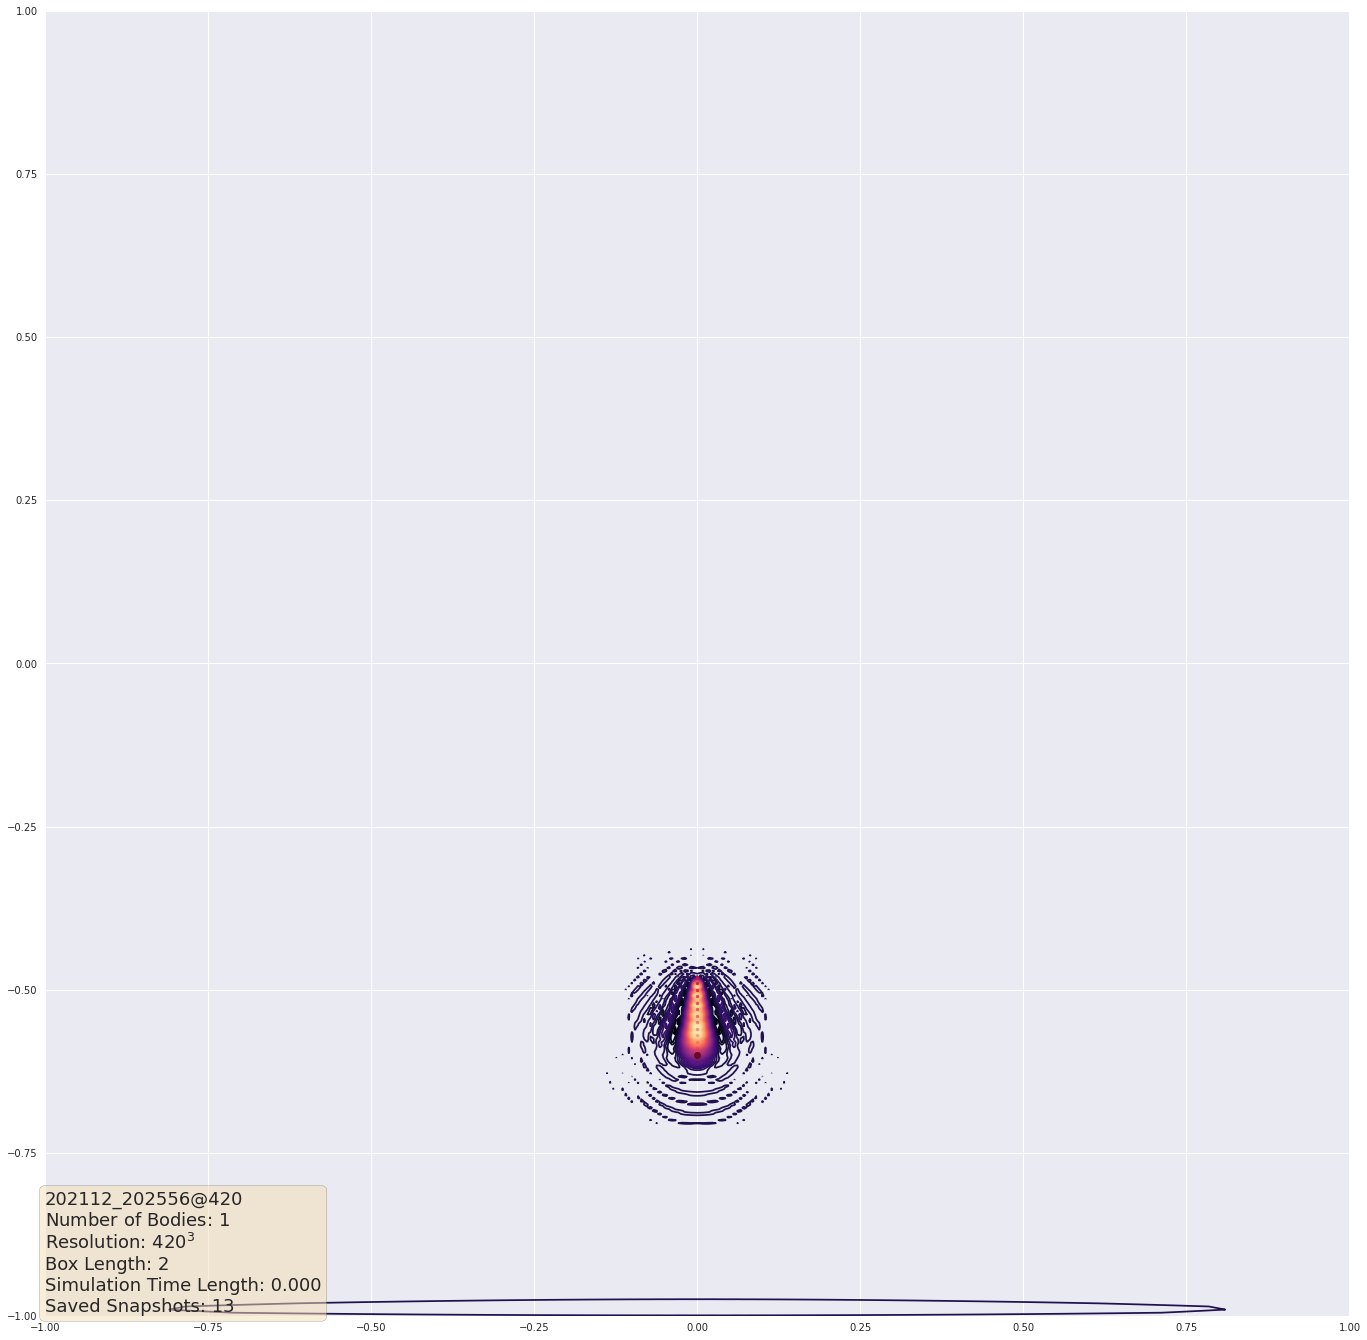

In [39]:
Plot_ULD = True
# Number of ULDM Slices IN BETWEEN start and end (which are always plotted).
NSlices = 0


if NSlices >= EndNum:
    
    NSlices = EndNum

try:
    TSD = TimeStamp
except NameError:
    TimeStamp = 'Debug'

plt.clf()

fig = plt.figure(figsize=(24, 24))
ax = fig.add_subplot(111)

Zoom2D = 1

Boundary = LengthFS/(2*Zoom2D)

plt.xlim([-Boundary,Boundary])
plt.ylim([-Boundary,Boundary])

ax.set_aspect('equal', adjustable='box')

for i in range(EndNum):
    
    TMStateLoc = TMdata[i]
    
    if i == 0:
        for particleID in range(len(particles)):
        
            Color = Colors[np.mod(particleID,5)] # 0, 0.5
        
            TMx = TMStateLoc[int(6*particleID)]
            TMy = TMStateLoc[int(6*particleID+1)]
            plt.plot([TMy],[TMx],'o',color=(0.5*Color[0],0.5*Color[1],0.5*Color[2],1))
        
    
    Alpha = 0.1+9*i/(10*EndNum)
    
    for particleID in range(len(particles)):
        
        Color = Colors[np.mod(particleID,5)] # 0, 0.5
        
        TMx = TMStateLoc[int(6*particleID)]
        TMy = TMStateLoc[int(6*particleID+1)]
        plt.plot([TMy],[TMx],'.',color=(Color[0],Color[1],Color[2],Alpha))
        
        
planemax = np.max(data)
planemin = np.min(data)

levels = np.linspace(planemin, planemax, int(resol/(8)))

PlotRange = np.linspace(-LengthFS/2, LengthFS/2,resol,endpoint = False)

if Plot_ULD:
    plt.contour(PlotRange,PlotRange,data[1], levels=levels,cmap = Palette)
    plt.contour(PlotRange,PlotRange,data[EndNum-1], levels=levels,cmap = Palette)


    if NSlices != 0 and EndNum >= NSlices:

        Blink = EndNum/(NSlices+1)

        Index = np.linspace(Blink,EndNum-Blink,NSlices)

        for Ind in Index:
            j = int(Ind)
            plt.contour(PlotRange,PlotRange,data[j], levels=levels,cmap = Palette)

        
ax.grid(True)


Info = '\n'.join((
    TimeStamp,
    r'Number of Bodies: $%.0f$' % (NBo, ),
    r'Resolution: $%.0f^3$' % (resol, ),
    r'Box Length: %.0f' % (length, ),
    r'Simulation Time Length: %.3f' % (DurationDisp, ),
    r'Saved Snapshots: %.0f' % (EndNum)
    ))


# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0, 0, Info, transform=ax.transAxes, fontsize=18,
        verticalalignment='bottom', bbox=props)

TrajName = '{}{}{}{}{}'.format("./",save_path,"/_",TimeStamp,'.jpg')
plt.savefig(TrajName, format='jpg', dpi=72)

plt.show()

## Energy

[100]
1
202112_202556@420
Number of Bodies: $1$
Rate of Change in Mechanical Energy: ($\mathcal{E}/\mathcal{T}$): -756274.6676
Simulation Time Length: 0.000


<Figure size 576x396 with 0 Axes>

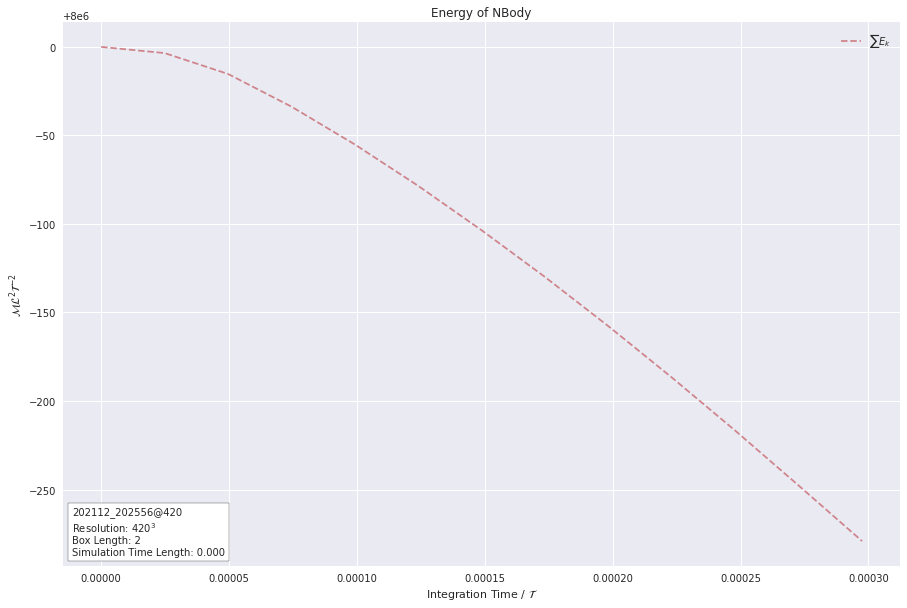

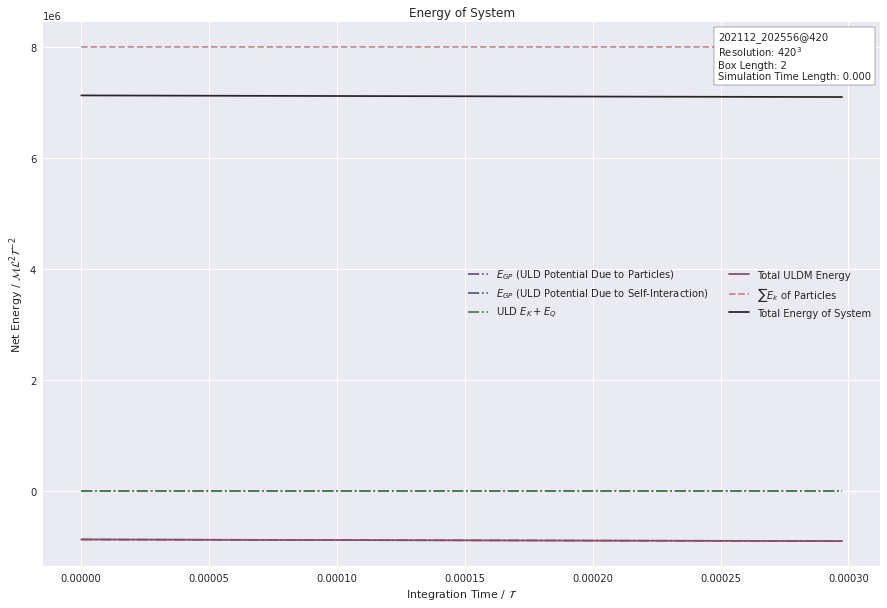

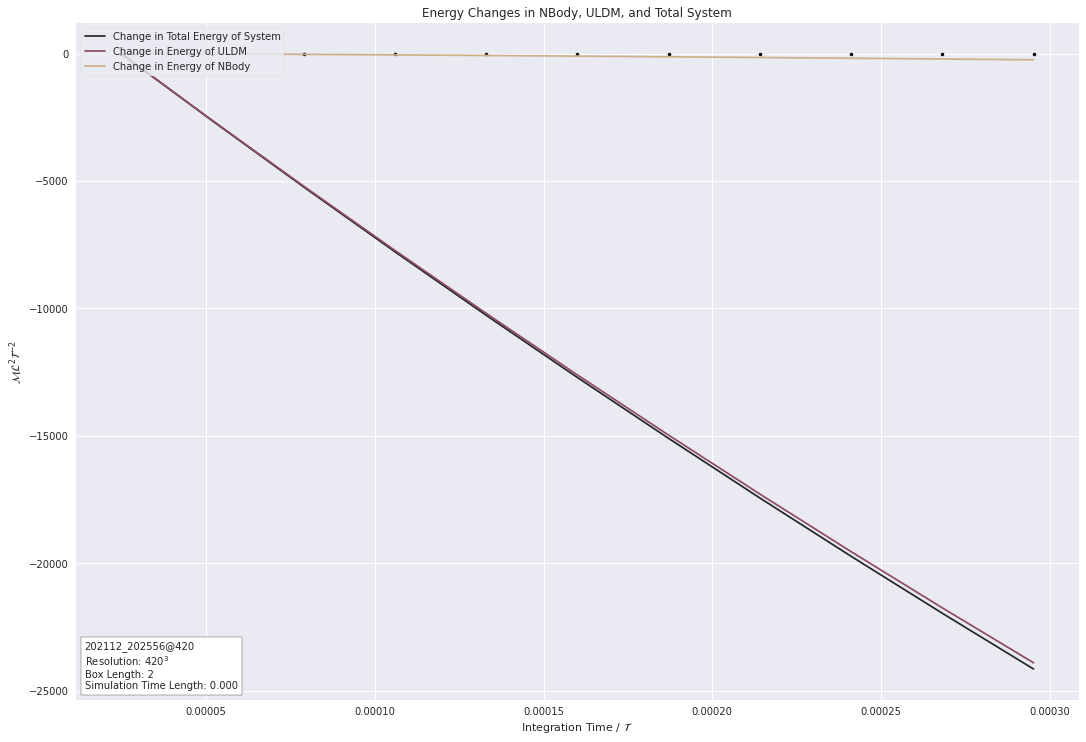

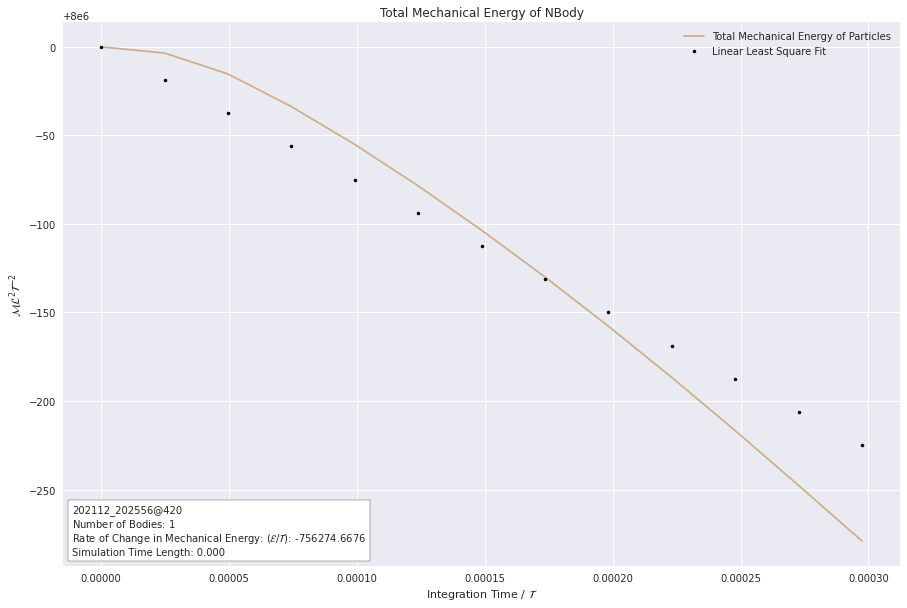

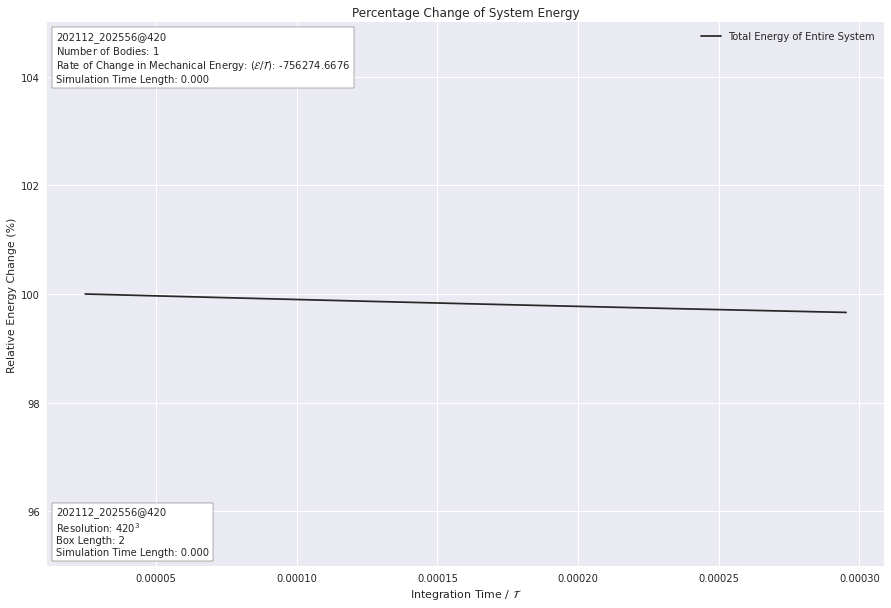

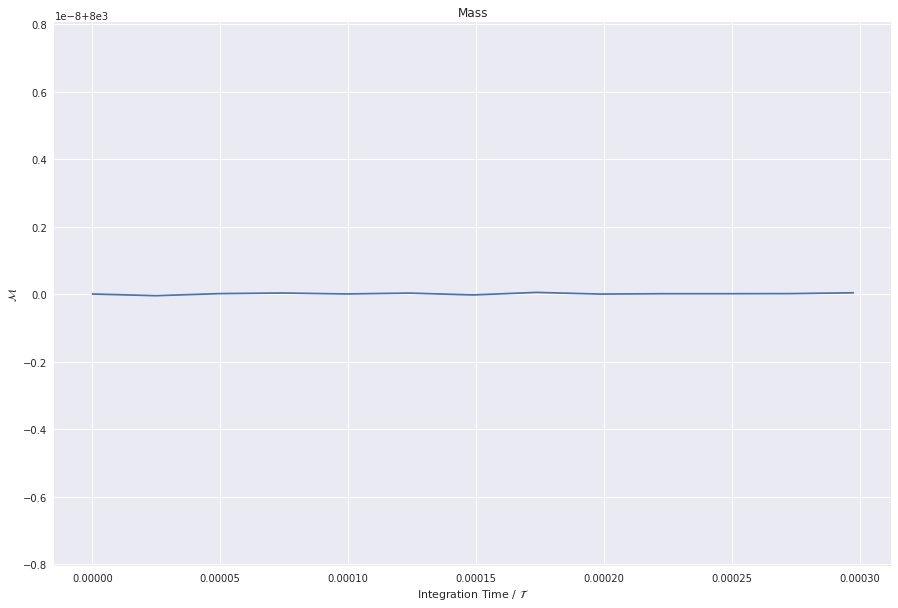

In [40]:
EFigSize = (15,10)

Snap = False
loc = save_path + '/' + TimeStamp

plt.clf()

#==================================================================================================
## Naming
EnergyName = '{}{}{}'.format("./",loc,"/Energy_Total.jpg")
EnergyDName = '{}{}{}'.format("./",loc,"/Energy_Delta.jpg")
EnergyMName = '{}{}{}'.format("./",loc,"/Energy_Mech.jpg")
EnergyD2Name = '{}{}{}'.format("./",loc,"/Energy_Pct.jpg")

#==================================================================================================
## Analysis
#
# Load ULDM Energy

egylist = np.load('{}{}'.format(loc, '/Outputs/egylist.npy'),allow_pickle=True)
egpcmlist = np.load('{}{}'.format(loc, '/Outputs/egpcmlist.npy'),allow_pickle=True)
egpsilist = np.load('{}{}'.format(loc, '/Outputs/egpsilist.npy'),allow_pickle=True)
ekandqlist = np.load('{}{}'.format(loc, '/Outputs/ekandqlist.npy'),allow_pickle=True)
mtotlist = np.load('{}{}'.format(loc, '/Outputs/masseslist.npy'),allow_pickle=True)

# Reconstruct NBody Energy
NBo, KS, PS = PyULH.NBodyEnergy(particles,EndNum,TMdata,m_mass_unit,a)

# Translating Snapshots back to Time
timerange = np.linspace(0,duration,save_number+1)

Tp = np.linspace(0,EndNum-1,EndNum)
Tp = Tp * duration / (save_number+1)

Tpt = np.linspace(1,EndNum,EndNum-2,endpoint = False) 
Tpt = Tpt/(save_number+1) * duration

KSD = KS - KS[1]
PSD = PS - PS[1]

egylistD = egylist - egylist[1]
TotalED = PSD+KSD+egylistD

MES = PS + KS

MESD = PSD + KSD

MESGrad = np.sum(MESD)/np.sum(Tp)

TotalER = (KS + PS + egylist) / (KS[1]+PS[1]+egylist[1])*100

ULDER =  egylist/ egylist[1]


#==================================================================================================
## Compile Printing Boxes

SimInfo = '\n'.join((
    TimeStamp,
    r'Resolution: $%.0f^3$' % (resol, ),
    r'Box Length: %.0f' % (length, ),
    r'Simulation Time Length: %.3f' % (DurationDisp, )
    ))

NBodyInfo = '\n'.join((
    TimeStamp,
    r'Number of Bodies: $%.0f$' % (NBo, ),
    r'Rate of Change in Mechanical Energy: ($\mathcal{E}/\mathcal{T}$): %.4f' % (MESGrad, ),
    r'Simulation Time Length: %.3f' % (DurationDisp, )
    ))

print(NBodyInfo)

#==================================================================================================
## Plots
# NBody Energy Diagram
fig = plt.figure(figsize= EFigSize)
ax = fig.add_subplot(111)
InfoBox = AnchoredText(SimInfo, loc=3)
ax.add_artist(InfoBox)

plt.plot(Tp,KS,ENStyle,color = EKColor,label = '$\sum E_k$')
#plt.ylim(0,)
if len(particles) >= 2:
    plt.plot(Tp,PS,ENStyle,color = EPColor,label = '$\sum E_p$')
    plt.plot(Tp,PS+KS,ETStyle,color = ENColor, label = '$E_k + E_p$')
#plt.plot(Tp,0*Tp,'k--')

plt.title('Energy of NBody')
plt.xlabel('Integration Time / $\mathcal{T}$')
plt.ylabel('$\mathcal{M}\mathcal{L}^2\mathcal{T}^{-2}$')

plt.legend()

plt.show()

#==================================================================================================
# System Energy Diagram
fig = plt.figure(figsize= EFigSize)
ax = fig.add_subplot(111)
InfoBox = AnchoredText(SimInfo,loc = 1)
ax.add_artist(InfoBox)

plt.plot(Tp,egpcmlist,EUStyle,color = EGColor,label='$E_{GP}$ (ULD Potential Due to Particles)')
plt.plot(Tp,egpsilist,EUStyle,color = ERColor,label='$E_{GP}$ (ULD Potential Due to Self-Interaction)')
plt.plot(Tp,ekandqlist,EUStyle,color = EQColor,label='ULD $E_{K}+E_{Q}$')

plt.plot(Tp,egylist,ETStyle,color = EUColor,label='Total ULDM Energy')

plt.plot(Tp,KS,ENStyle,color = EKColor,label = '$\sum E_k$ of Particles')

if len(particles) >= 2:
    plt.plot(Tp,PS,ENStyle,color = EPColor,label = '$\sum E_p$ of Particles')
    plt.plot(Tp,PS+KS,ETStyle,color = ENColor,label = 'Total Mechanical Energy of Particles')


plt.plot(Tp,PS+KS+egylist,ETStyle,color = ETColor, label = 'Total Energy of System')
plt.legend(ncol=2,loc = 'best')

plt.xlabel('Integration Time / $\mathcal{T}$')
plt.ylabel('Net Energy / $\mathcal{M}\mathcal{L}^2\mathcal{T}^{-2}$')

plt.title('Energy of System')
plt.savefig(EnergyName, format='jpg', dpi=72)

plt.show()

#==================================================================================================
# The Advanced Energy Change Diagram
fig = plt.figure(figsize= EFigSize)
ax = fig.add_subplot(111)
InfoBox = AnchoredText(SimInfo, loc=3)
ax.add_artist(InfoBox)

plt.plot(Tpt,TotalED[1:-1],ETStyle,color = ETColor, label = 'Change in Total Energy of System')
plt.plot(Tpt,0*Tpt,HelperStyle, label = '')
plt.plot(Tpt,egylistD[1:-1],ETStyle,color = EUColor, label = 'Change in Energy of ULDM')
plt.plot(Tpt,KSD[1:-1]+PSD[1:-1],ETStyle,color = ENColor, label = 'Change in Energy of NBody')

plt.legend(loc = 'upper left',frameon = True)

plt.xlabel('Integration Time / $\mathcal{T}$')
plt.ylabel('$\mathcal{M}\mathcal{L}^2\mathcal{T}^{-2}$')

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

# plt.ylim([98,102])
plt.title('Energy Changes in NBody, ULDM, and Total System')
plt.savefig(EnergyDName, format='jpg', dpi=72)

plt.show()

#==================================================================================================
## Total Mechanical Energy Plot
fig = plt.figure(figsize= EFigSize)
ax = fig.add_subplot(111)
InfoBoxM = AnchoredText(NBodyInfo, loc=3)
ax.add_artist(InfoBoxM)

plt.plot(Tp,MES,ETStyle,color = ENColor, label = 'Total Mechanical Energy of Particles')

plt.plot(Tp,Tp*MESGrad+MES[0],HelperStyle, label = 'Linear Least Square Fit')

plt.xlabel('Integration Time / $\mathcal{T}$')
plt.ylabel('$\mathcal{M}\mathcal{L}^2\mathcal{T}^{-2}$')

plt.legend()
plt.title('Total Mechanical Energy of NBody')
plt.savefig(EnergyMName, format='jpg', dpi=72)

plt.show()



#==================================================================================================
# The Advanced Energy Change Ratio Diagram
fig = plt.figure(figsize= EFigSize)
ax = fig.add_subplot(111)
InfoBoxD = AnchoredText(SimInfo, loc=3)
ax.add_artist(InfoBoxD)
InfoBoxD2 = AnchoredText(NBodyInfo, loc=2)
ax.add_artist(InfoBoxD2)

ax.plot(Tpt,TotalER[1:-1],ETStyle, color = ETColor, label = 'Total Energy of Entire System')
ax.set_xlabel('Integration Time / $\mathcal{T}$')
ax.legend()

plt.xlabel('Integration Time / $\mathcal{T}$')
ax.set_ylabel('Relative Energy Change (%)')
ax.set_ylim([95,105])
ax.set_title('Percentage Change of System Energy')

plt.savefig(EnergyD2Name, format='jpg', dpi=72)

plt.show()


#==================================================================================================
# The Net Mass Diagram

MassData = np.load('{}{}'.format(loc, '/Outputs/ULDMass.npy'),allow_pickle=True)

fig = plt.figure(figsize= EFigSize)
ax = fig.add_subplot(111)

ax.plot(Tp,MassData)
ax.set_xlabel('Integration Time / $\mathcal{T}$')

plt.xlabel('Integration Time / $\mathcal{T}$')
ax.set_ylabel('$\mathcal{M}$')
ax.set_title('Mass')
plt.show()


### Field Argument Plotter

In [ ]:
try:
    VTimeStamp = TimeStamp
except NameError:
    VTimeStamp = str('Debug')

loc = save_path + '/' + TimeStamp

AnimName = '{}{}'.format(loc,"/AnimPhase.mp4")

print("Saving ",AnimName)

plot_axis = 'z' #axis that is set to zero
plt.ioff()
fig0, ax0 = plt.subplots(figsize=(16, 16), dpi=72)
ax0.set_aspect('equal')

PlotRange = np.linspace(-LengthFS/2, LengthFS/2,resol,endpoint = False)

# print(PlotRange)

FPS = 10


def animate3(i):
    ax0.cla()

    ax0.get_xaxis().set_ticks([])
    ax0.get_yaxis().set_ticks([])
    
    
    Plane = np.real(phasedata[i])
    
    ax0.imshow(Plane,cmap = 'twilight',origin = 'lower',
               vmin = -np.pi, vmax = np.pi,
               extent = (-LengthFS/2,LengthFS/2-LengthFS/resol,-LengthFS/2,LengthFS/2-LengthFS/resol),
              interpolation = 'none')
    
    TMStateLoc = TMdata[i]
    
    for particleID in range(len(particles)):
        
        Color = Colors[np.mod(particleID,5)] # 0, 0.5
        
        TMx = TMStateLoc[int(6*particleID)]
        TMy = TMStateLoc[int(6*particleID+1)]
        TMz = TMStateLoc[int(6*particleID+2)]
        
        Vx = TMStateLoc[int(6*particleID+3)]
        Vy = TMStateLoc[int(6*particleID+4)]
        Vz = TMStateLoc[int(6*particleID+5)]
        ax0.plot([TMy],[TMx],'o',color=(Color[0],Color[1],Color[2],1))
        ax0.quiver([TMy],[TMx],[Vy],[Vx])
  
    if i%FPS == 0 and i!= 0:
        print('Animated %.0f seconds out of %.2f seconds of data.' % (i/FPS, EndNum/FPS))
    
    if i == EndNum-1:
        print('Animation Complete')

interval = 0.15 #in seconds
ani3 = matplotlib.animation.FuncAnimation(fig0,animate3,EndNum,interval=interval*1e+3,blit=False)



Writer = matplotlib.animation.writers['ffmpeg']

writer = Writer(fps=FPS, metadata=dict(artist='PyUltraLightF'))

ani3.save(AnimName, writer=writer)


'''

from IPython.display import HTML
animated_plot3 = HTML(ani3.to_jshtml())

fig0.clear()
display(animated_plot3) 

'''

## [Animation] 2D Mass Density

Saving  2021Runs/202112_202556@420/Anim2D.mp4
Initial Field is Uniform. Evaluating Change Ratio.
Max:2.0560026880744027,Min:0.8382700244261141
Animated 1 seconds out of 1.30 seconds of data.
Animation Complete


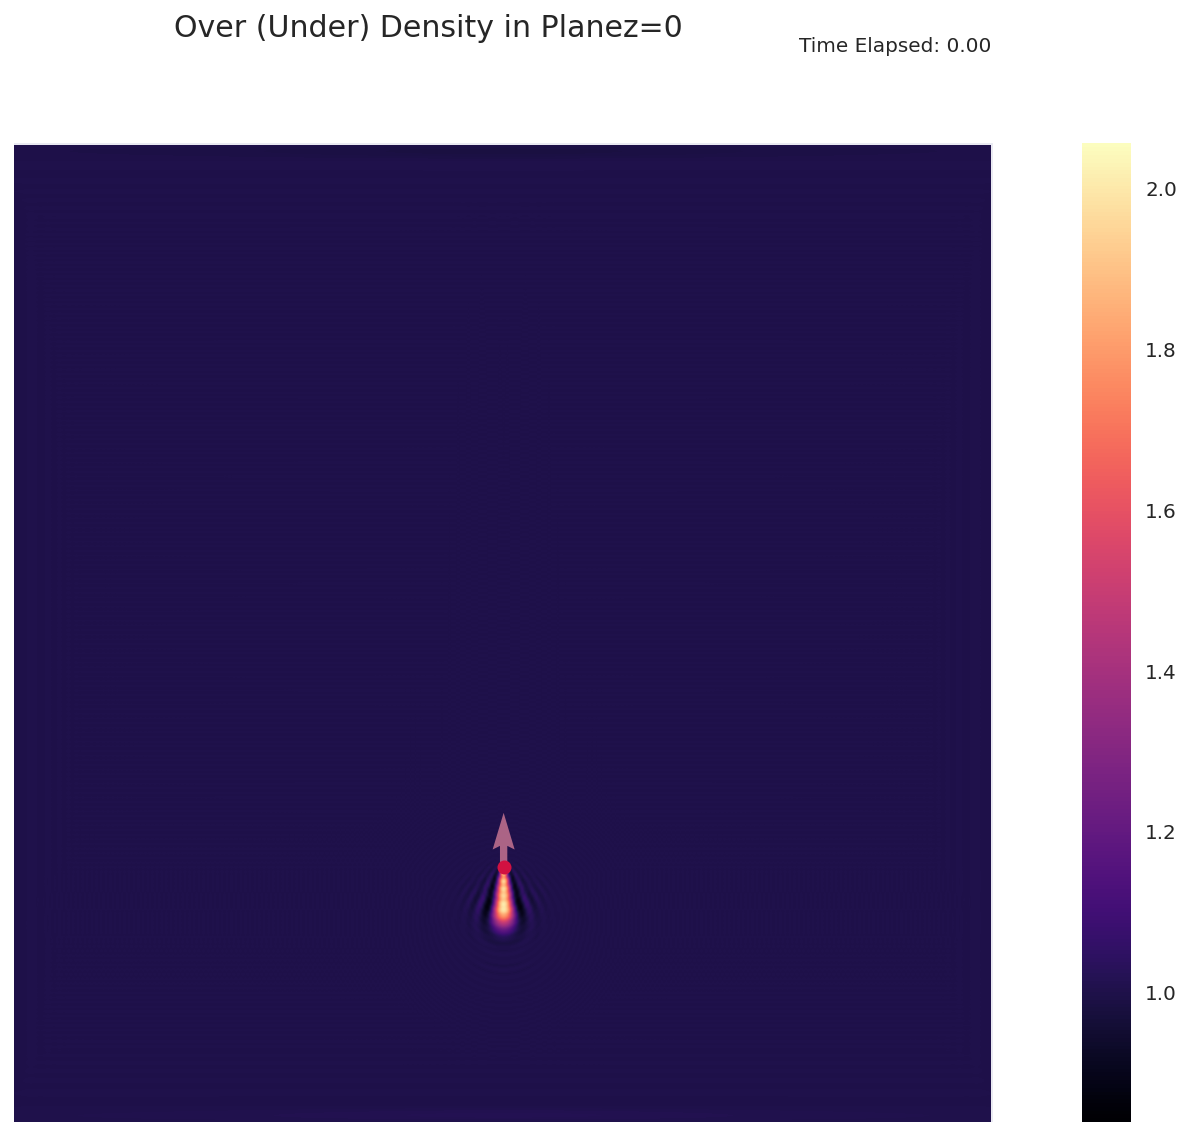

In [41]:
Loga = False
Contour = False

try:
    VTimeStamp = TimeStamp
except NameError:
    VTimeStamp = str('Debug')

AnimName = '{}{}'.format(loc,"/Anim2D.mp4")

print("Saving ",AnimName)

plot_axis = 'z' #axis that is set to zero
plt.ioff()
fig0, ax0 = plt.subplots(figsize=(16, 9), dpi=144)
ax0.set_aspect('equal')

Tp = np.linspace(0,EndNum-1,EndNum)
Tp = Tp * duration / (save_number+1)

DensityGR = Density

if Loga:
    
    if Uniform:
        data0 = np.log(np.array(data)/DensityGR)
        print("Initial Field is Uniform. Evaluating Change Ratio.")
        planemax = np.max(data0)
        planemin = np.min(data0)
        TITLETEXT = 'Logarithmic Over (Under) density in Plane'


    else:
        data0 = np.log(data)
        planemax = np.max(data0)
        planemin = -10
        TITLETEXT = 'Logarithmic Mass Density in Plane'
    
    print("Using Log Plot, the Contour Level Limits Are")
    
    
else:
    if Uniform:
        data0 = np.array(data)/DensityGR
        print("Initial Field is Uniform. Evaluating Change Ratio.")
        planemax = np.max(data0)
        planemin = np.min(data0)
        TITLETEXT = 'Over (Under) Density in Plane'


    else:
        data0 = (data)
        planemax = np.max(data0)
        planemin = np.min(data0)
        TITLETEXT = 'Mass Density in Plane'



levels = np.linspace(planemin, planemax, int(resol))
print(f"Max:{planemax},Min:{planemin}")

PlotRange = np.linspace(-LengthFS/2, LengthFS/2,resol,endpoint = False)

# print(PlotRange)

FPS = 10


def animate0(i):
    ax0.cla()
    ax0.set_aspect('equal')
    ax0.set_xlim([-LengthFS/2,LengthFS/2])
    ax0.set_ylim([-LengthFS/2,LengthFS/2])
    ax0.get_xaxis().set_ticks([])
    ax0.get_yaxis().set_ticks([])
    
    if Contour:
        mappable = ax0.contour(PlotRange,PlotRange,data0[i], levels=levels,cmap = Palette)
    
    else:
        mappable = ax0.imshow(data0[i],cmap = Palette,origin = 'lower',
                  vmin = planemin, vmax = planemax, interpolation = 'bicubic',
                   extent = (-LengthFS/2,LengthFS/2-LengthFS/resol,-LengthFS/2,LengthFS/2-LengthFS/resol))
    
    if i == 1:
        fig0.colorbar(mappable,ax=ax0)

    TMStateLoc = TMdata[i]
    
    for particleID in range(len(particles)):
        
        Color = Colors[np.mod(particleID,5)] # 0, 0.5
        
        TMx = TMStateLoc[int(6*particleID)]
        TMy = TMStateLoc[int(6*particleID+1)]
        TMz = TMStateLoc[int(6*particleID+2)]
        
        Vx = TMStateLoc[int(6*particleID+3)]
        Vy = TMStateLoc[int(6*particleID+4)]
        Vz = TMStateLoc[int(6*particleID+5)]
        ax0.plot([TMy],[TMx],'o',color=(Color[0],Color[1],Color[2],1))
        ax0.quiver([TMy],[TMx],[Vy],[Vx],color=(0.5+0.5*Color[0],0.5+0.5*Color[1],0.5+0.5*Color[2],0.7))
        
    fig0.suptitle('{}{}{}'.format(TITLETEXT, plot_axis, '=0'), fontsize = 15)
    ax0.text(0.90, 1.1, '{}{:.2f}'.format('Time Elapsed: ', Tp[i]), horizontalalignment='center', verticalalignment='center', transform=ax0.transAxes)
    
    if i%FPS == 0 and i!= 0:
        print('Animated %.0f seconds out of %.2f seconds of data.' % (i/FPS, EndNum/FPS))
    
    if i == EndNum-1:
        print('Animation Complete')

interval = 0.15 #in seconds
ani0 = matplotlib.animation.FuncAnimation(fig0,animate0,EndNum,interval=interval*1e+3,blit=False)


Writer = matplotlib.animation.writers['ffmpeg']

writer = Writer(fps=FPS, metadata=dict(artist='PyUltraLightF'))


ani0.save(AnimName, writer=writer)

#from IPython.display import HTML
#animated_plot0 = HTML(ani0.to_jshtml())

#fig0.clear()
#display(animated_plot0) 


## [Animation] Gravitational Field Slice

In [ ]:
try:
    VTimeStamp = TimeStamp
except NameError:
    VTimeStamp = str('Debug')

AnimName = '{}{}'.format(loc,"/AnimFieldSlice.mp4")

print("Saving ",AnimName)

# Initialization
fig = plt.figure(figsize=(12, 12))
ax = fig.gca(projection='3d')

ax.view_init(90, 0)

PlotRange = np.linspace(-length/2, length/2,resol)

zoom = 0.8

FPS = 15 

x3D, y3D = np.meshgrid(PlotRange,PlotRange)

phidataP = np.array(phidata)*-1

planemax = np.max(phidataP)*1.2
planemin = np.min(phidataP)

print(planemin,planemax)

levels = np.linspace(planemin, planemax, 100)

def animate(i):
    fig.clear()
    global FPS
    
    TMStateLoc = TMdata[i]
    ax = fig.gca(projection='3d')

    ax.view_init(30, 45)

    ax.set_zlim3d(planemin, planemax)
    ax.set_ylim3d(-length/(2*zoom), length/(2*zoom))                    
    ax.set_xlim3d(-length/(2*zoom), length/(2*zoom))

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    
  
    ax.plot_wireframe(x3D,y3D,phidataP[i],rcount = resol, ccount = resol)
 
    
    for particleID in range(len(particles)):
        TMx = TMStateLoc[int(6*particleID)]
        TMy = TMStateLoc[int(6*particleID+1)]
        TMz = TMStateLoc[int(6*particleID+2)]
        
        Vx = TMStateLoc[int(6*particleID+3)]
        Vy = TMStateLoc[int(6*particleID+4)]
        Vz = TMStateLoc[int(6*particleID+5)]
        ax.plot([TMy],[TMx],[TMz],'ko')
        ax.quiver([TMy],[TMx],[TMz],[Vy],[Vx],[Vz],length=length/(resol*zoom), normalize=False)
    #ax.plot([TMS[i,0]],[TMS[i,1]],[TMS[i,2]],'ro')
    
        ax.text(TMy, TMx, TMz, '{}{}{}'.format(particleID,'Particle Snapshot # ', i))

    
    if i%FPS == 0 and i!= 0:
        print('Animated %.0f seconds out of %.2f seconds of data.' % (i/FPS, EndNum/FPS))
        
    if i == EndNum-1:
        print('Animation Complete')
        
    plt.draw() 

Writer = matplotlib.animation.writers['ffmpeg']

writer = Writer(fps=FPS, metadata=dict(artist='PyUltraLightF'))

interval = 0.05 #in seconds


ani = matplotlib.animation.FuncAnimation(fig,animate,EndNum,interval=interval*1e+3,blit=False)

ani.save(AnimName, writer=writer)

from IPython.display import HTML
animated_plot = HTML(ani.to_jshtml())

fig.clear()
display(animated_plot0) 
 

# Acceleration of Particles

In [ ]:
pID = 0 # 0,1,2,...

plt.clf()
plt.figure(figsize=(16, 9))

graddataP = (graddata)
for i in range(EndNum):
    pID = pID*3
    plt.plot(i,graddataP[i][0],'ro',label = '$x$')
    plt.plot(i,graddataP[i][1],'g.',label = '$y$')
    plt.plot(i,graddataP[i][2],'b.',label = '$z$')

plt.xlabel('Snapshot Number')
plt.ylabel('Particle Acceleration')
plt.show()

## [Bonus Interactive]: 3D Field Visualization

Loads all data into RAM. Very slow.

In [ ]:
if save_rho:
    
    with open('{}{}'.format(save_path, '/timestamp.txt'), 'r') as timestamp:
        ts = timestamp.read()
        print('PyUL NBody: Loading Folder',ts)

    loc = save_path + '/' + ts

    import time   
    import warnings 
    warnings.filterwarnings("ignore")
    plt.ioff()

    EndNum = 0
    Rhodata = []
    TMdata = []

    for x in np.arange(0,save_number+1,1):
    #for x in np.arange(0,550,1):    

        try:

            Rhodata.append(np.load('{}{}{}{}'.format(loc, '/rho_#', x, '.npy')))
            TMdata.append(np.load('{}{}{}{}'.format(loc, '/TM_#', x, '.npy')))
            EndNum += 1
        except FileNotFoundError:

            TimeStamp = ts
            print("PyUL NBody: Run incomplete or the storage is corrupt!")

            break

    print("PyUL NBody: Loaded", EndNum, "Data Entries. Which one to plot?")
    
    PlotNum = int(input())

    import plotly.graph_objects as go
    
    import plotly.io as pio
    
    import numpy as np
    
    if Uniform:
        Rhodata = np.log(np.array(Rhodata))
        
    

    HL = length/2
    XP, YP, ZP = np.mgrid[-HL:HL:resol/4*1j, -HL:HL:resol/4*1j, -HL:HL:resol/4*1j]

    print(len(XP))
    values = Rhodata[PlotNum]
    
    values = values.flatten()
    
    shrink = int(resol/4)**3
    
    Values = np.zeros(shrink)
    
    for ii in range(shrink):
        Values[ii] = values[int(ii*4)]

    fig3D = go.Figure(data=go.Volume(
        x=XP.flatten(),
        y=YP.flatten(),
        z=ZP.flatten(),
        value=Values,
        isomin=np.min(Rhodata),
        isomax=np.max(Rhodata),
        opacity=0.02, # needs to be small to see through all surfaces
        surface_count=int(resol/4), # needs to be a large number for good volume rendering
        ))

else:
    raise RuntimeError("You did not save field data!")

In [ ]:
import plotly.io as pio
pio.write_html(fig3D, 'Trial.html')

## [Bonus Interactive]: 3D Density Visualization

In [ ]:
print(phidataP[1])

In [ ]:
import plotly.graph_objects as go
 
import plotly.io as pio
import numpy as np

import pandas as pd

phidataPL = pd.DataFrame(data=phidataP[287], index=None, columns=None)

fig = go.Figure(data=[go.Surface(z=phidataPL.values)])

#fig.update_layout(title='$z=0$', autosize=False,width=500, height=500,margin=dict(l=65, r=50, b=65, t=90))

fig.show()

In [ ]:
pio.write_html(fig, 'Soliton512.html')

In [ ]:
print(phidataPL)

In [ ]:
z_data = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/api_docs/mt_bruno_elevation.csv')

fig = go.Figure(data=[go.Surface(z=z_data.values)])

fig.update_layout(title='Mt Bruno Elevation', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))

fig.show()

In [ ]:
print(z_data)

In [ ]:
Green = PyUL.makeDCTGreen(192)

print(Green.size)

In [ ]:
np.save('./Green Functions/G192.npy',Green)